# Analyzing the survey resulys

In [1]:
from os import path
import copy
import warnings
import textwrap

import numpy as np
import pandas as pd
from scipy.optimize import brentq
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import seaborn as sns

%matplotlib inline

warnings.filterwarnings("ignore")

## Load the survey results
And delete the pilot data.

We display the first row, with the column names. You'll see that this person filled it out in French, so there are NaN values for all the questions in English.

If you scroll to the right, you can read all of the questions in the survey and see this participants' responses to the questions in French.

In [2]:
survey = pd.read_csv("Doing Open Science in Grad School.csv", dtype=str)
##########################################
# non_pilot_data = np.arange(7, len(survey))
# survey = survey.iloc[non_pilot_data]
# survey.reset_index(drop=True, inplace=True)
print("We have %d responses" % len(survey))

pd.set_option("display.max_columns", None)
survey.head(1)

We have 44 responses


,Timestamp,Select the language you are most comfortable using to fill out the form,We plan to openly share the results of this survey. No identifying information will be shared. Do you consent to this?,Institution / University,I am a,Department,"What do you think of when you hear the words ""open science""?",What's your experience CREATING open-science objects? (you can select multiple options in each row) [Registered reports],What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open-access publication],"What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open methods (e.g., lab notebooks)]",What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open hardware],What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open data],What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open software],What's your experience CREATING open-science objects? (you can select multiple options in each row) [Open educational resources],"What's your experience CREATING open-science objects? (you can select multiple options in each row) [Equity, diversity, and inclusion]",What's your experience CREATING open-science objects? (you can select multiple options in each row) [Public outreach / citizen science],What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Registered reports],What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open-access publication],"What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open methods (e.g., lab notebooks)]",What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open hardware],What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open data],What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open software],What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Open educational resources],"What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Equity, diversity, and inclusion]",What's your experience USING open-science objects that have been created and shared by others? (you can select multiple options in each row) [Public outreach / citizen science],What barriers do you face when trying to do open science? (you can select multiple options),What would help you make your research more open? (you can select multiple options),"Would you be interested in applying to host Open Science Office Hours? We're still determining what these office hours would look like. But for example, you might host every other month with another TA who has complimentary expertise in open science. Together, you'd help individuals find ways to make their research more open and reproducible, based on their skills and resources. You might tell them where to find tutorials on doing open science, where to get help debugging open software, ways to publish open access, where to find open data, etc. [As a volunteer]","Would you be interested in applying to host Open Science Office Hours? We're still determining what these office hours would look like. But for example, you might host every other month with another TA who has complimentary expertise in open science. Together, you'd help individuals find ways to make their re

# Before we analyze the data
## Let's shorten the column names & combine the English and French answers
As you can see above, the column names are very long; they're the full questions that were asked in the survey. Also, participants had the option of completing the survey in English or French.

Here, we load a file that contains
- the variable name for each question
- the English and French versions of each question

And we'll look at the first 4 rows.

In [3]:
cols = pd.read_csv(
    "survey_column_names_and_translations.csv",
    index_col="variable_name",
    dtype=str,
)
cols.head(4)

,en,fr
variable_name,,
language,Select the language you are most comfortable u...,Select the language you are most comfortable u...
university,Institution / University,Institution / Université
level,I am a,Je suis un.e
department,Department,Département


Now we'll use this information to convery the survey data into a simpler dataframe, with
- variable names as columns (instead of the full questions), and
- the English and French responses combined into one column per question (instead of there being 2 columns per question).

In [4]:
df = pd.DataFrame(columns=list(cols.index))
for col in list(cols.index):
    en, fr = cols.loc[col]
    df[col] = survey[en].fillna(survey[fr])

################################
# df["language"] = df["language"].fillna("English")
# df = df[df["language"] == "English"]


df.head(1)

,language,university,level,department,first_thoughts,create_registered_reports,create_open_access_publication,create_open_methods,create_open_hardware,create_open_data,create_open_software,create_open_educational_resources,create_equity_diversity_inclusion,create_public_outreach_citizen_science,use_registered_reports,use_open_access_publication,use_open_methods,use_open_hardware,use_open_data,use_open_software,use_open_educational_resources,use_equity_diversity_inclusion,use_public_outreach_citizen_science,barriers,resources_youd_like,host_volunteer,host_paid,learn_next,motivation,resources_that_helped,comments
0,NaN,University of Manchester - this is Andrew,NaN,Neuroscience and Experimental Psychology,Reproducibility,I'd like to create this,I've created this,I've created this,I'd like to create this,I've created this,I've created this,I've created this,I've created this,I'd like to create this,I've used this,I've used this,I've used this,I've used this,I've used this,I've used this,I've used this,I've used this,I've used this,I think I'm lucky to not face any barriers (th...,am leaving this blank,Yes,Yes,NaN,NaN,NaN,Looks great!


In [5]:
print('Number of participants: ', len(df))

Number of participants:  44


## Let's create regex expressions for categorizing answers

There are a few reasons for doing this:
1. to combine answers given in French and English. E.g., We'll replace "I don't know what this is" and "Je ne sais pas ce que c'est." with "dont_know".
2. for open ended questions, we might want to combine anwers that differ slightly but refer to a similar concept. E.g., the answers "McGill" or "mcgill university" will be replaced with "McGill".
3. for length multiple-choice answers, we want to replace them with a simple variable name with no spaces. E.g., "I don't know what this is" will be replaced with "dont_know".

In all these dictionaries, the values are the regex expressions that will be used to search for text and replace it with the corresponding keys.


In [6]:
uni_regexs = {
    "McGill University": "[Mm]c[Gg]ill",
    "Concordia University": "[Cc]oncordia",
    "Université de Montréal": "[Mm]ontr[eé]al|[Uu]de[Mm]",
    "Columbia University": "[Cc]olumbia",
}


level_regexs = {
    "Undergrad": "[Uu]ndergrad|bac",
    "Masters": "[Mm]aster|[Mm]aitrise",
    "Early PhD": "student|début|[Bb][Ss]c",
    "Late PhD": "[Cc]andida",
    "Post-Doc": "([Pp]ost)([Dd]oc)",
    "Professor": "[Pp]rof",
}

dept_regexs = {
    "Neuro": "[Nn]euro|[Ii][Pp][Nn]",
    "Psych": "[Pp]sych",
    "Bio": "[Bb]io",
    "Engineering": "[Ee]ngineering",
    "Medical": "([Mm]edical|[Hh]ealth|[Ii]nfirm)",
    "Cognitive": "[Cc]ognit",
    "Education": "[Ed]ucat",
}

create_use_regexs = {
    "[blank]": "Non applicable",
    "dont_know": "I don't know what this is|Je ne sais pas ce que c'est",
    "never_used": "I've never used this|Je n'ai jamais utilisé cela",
    "have_used": "I've used this|J'ai utilisé ceci",
    "would_like_to_use": "I'd like to use this|J'aimerais pouvoir utiliser cela",
    "never_created": "I've never created this|Je n'ai jamais créé cela",
    "have_created": "I've created this|J'ai créé ceci",
    "would_like_to_create": "I'd like to create this|J'aimerais pouvoir créer cela",
}

# Descriptive visualization

Now we'll visualize the answers.

## Participant background
Here, we start by making a function for plotting the data from questions about the participant's background.

In [7]:
matplotlib.rcParams.update({"font.size": 20})
df_cleaned = copy.deepcopy(df)


def plot_categorical_column(
    column, regex_dict, ax, title=" ", drop_other=False, plot_kind="barh"
):
    # if a cell contains a string that matches a regex item,
    # replace the cell contents with the regex key
    column = column.dropna()
    for key, regex_str in regex_dict.items():
        column[column.str.contains(regex_str, regex=True)] = key
    #         df_cleaned[column.str.contains(regex_str, regex=True)] = key

    # drop responses that can't be categorized with any of the keys
    keys = regex_dict.keys()
    if drop_other:
        for i, row in column.iteritems():
            if row not in keys:
                column = column.drop(i)

    # plot
    column.value_counts(normalize=True).sort_values().plot(
        kind=plot_kind, ax=ax
    )
    ax.set_title(title)
    #     ax.set_xlim((0, 1))
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xticklabels([0, 50, 100])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

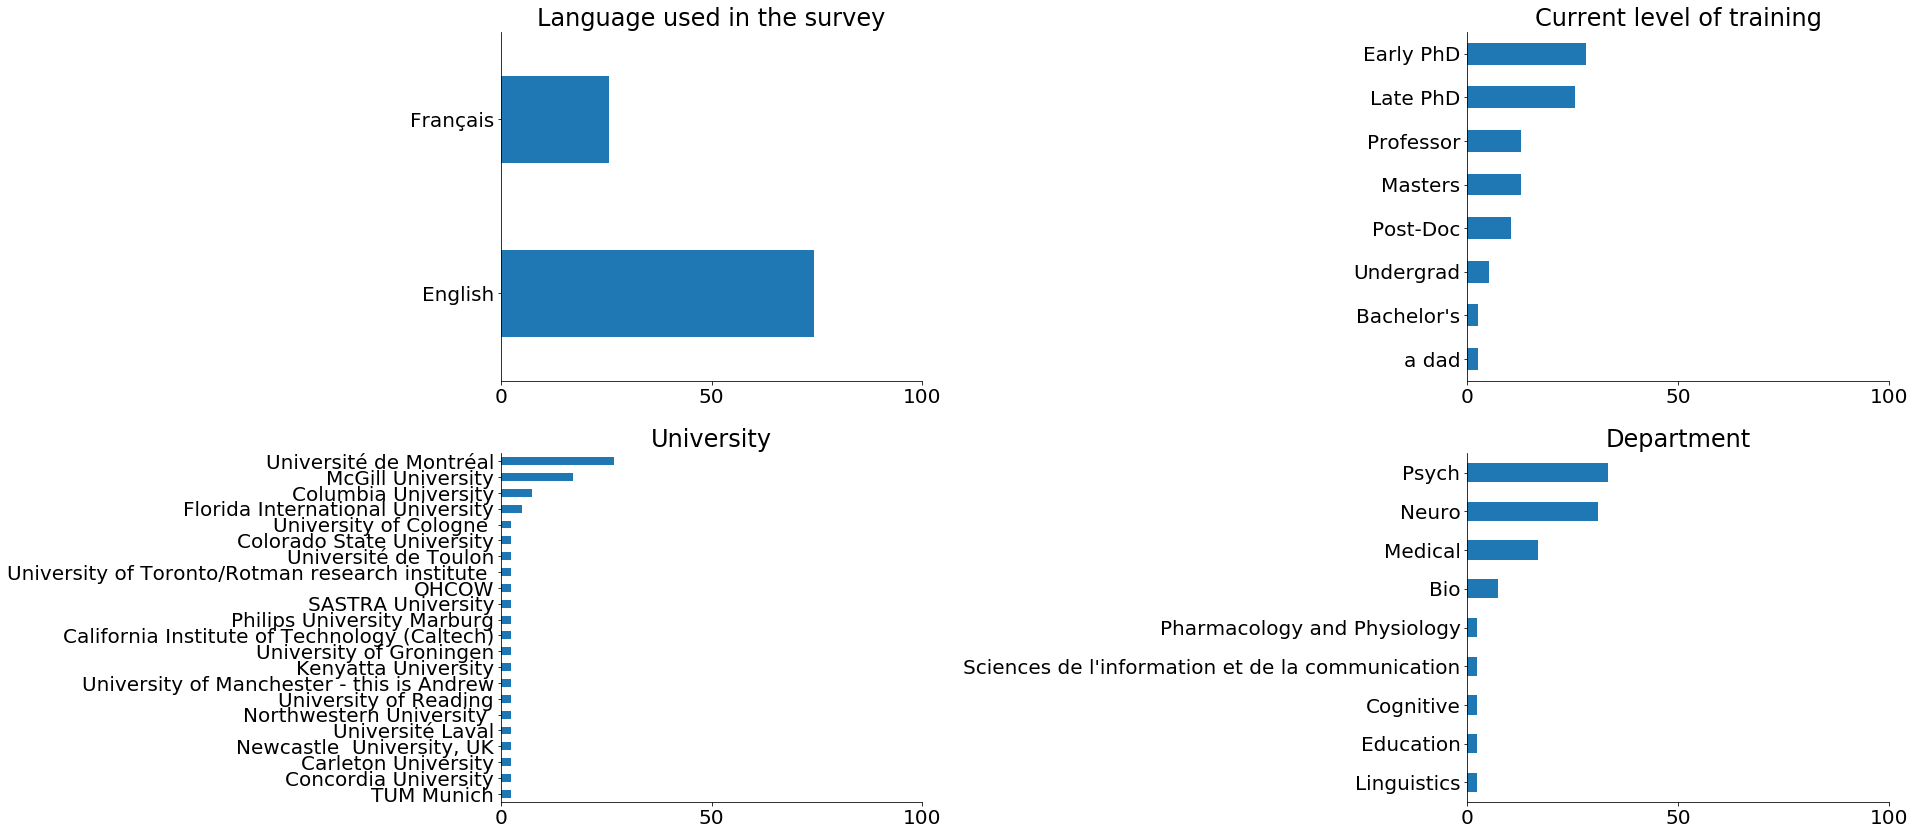

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(27, 12))

df["language"].value_counts(normalize=True).plot(
    kind="barh", title="Language used in the survey", ax=axs[0, 0]
)
axs[0, 0].set_xticks([0.0, 0.5, 1.0])
axs[0, 0].set_xticklabels([0, 50, 100])
# axs[0, 0].set_xlim((0, 1))
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].spines["top"].set_visible(False)

plot_categorical_column(
    df["level"],
    level_regexs,
    ax=axs[0, 1],
    title="Current level of training",
    plot_kind="barh",
)

# montreal_unis = [
#     "McGill University",
#     "Concordia University",
#     "Université de Montréal",
# ]
plot_categorical_column(
    df["university"],
    uni_regexs,
    ax=axs[1, 0],
    title="University",
    plot_kind="barh",
)

plot_categorical_column(
    df["department"],
    dept_regexs,
    ax=axs[1, 1],
    title="Department",
    plot_kind="barh",
)

plt.tight_layout()
plt.savefig("figures/participants_background.png", bbox_inches="tight")

## Participants experience creating and using open-science objects
Participants answered these two questions in a matrix of checkboxes, where
- the rows were the open-science objects
- the columns were their experience with them

We'll visualize their answers as matrices as well.

In [9]:
# first, let's replace the full answers with simpler keywords
# E.g., "I don't know what this is" becomes "dont_know"
for key, regex_str in create_use_regexs.items():
    df_cleaned.replace(
        to_replace=regex_str,
        value=key,
        inplace=True,
        limit=None,
        regex=True,
        method="pad",
    )

Let's create the matrix of counts of how many participants checked each box.

In [10]:
create_use_keys = list(create_use_regexs.keys())
create_use_cols = [
    col for col in list(df.columns) if "create_" in col or "use_" in col
]
mat = pd.DataFrame(columns=create_use_cols, index=create_use_keys, dtype=int)

n_participants = len(df_cleaned)
for col in create_use_cols:
    for row in create_use_keys:
        mat.at[row, col] = (
            df_cleaned[col].str.contains(row).sum() / n_participants * 100
        )


mat[create_use_cols] = mat[create_use_cols].astype(int)

Visualization

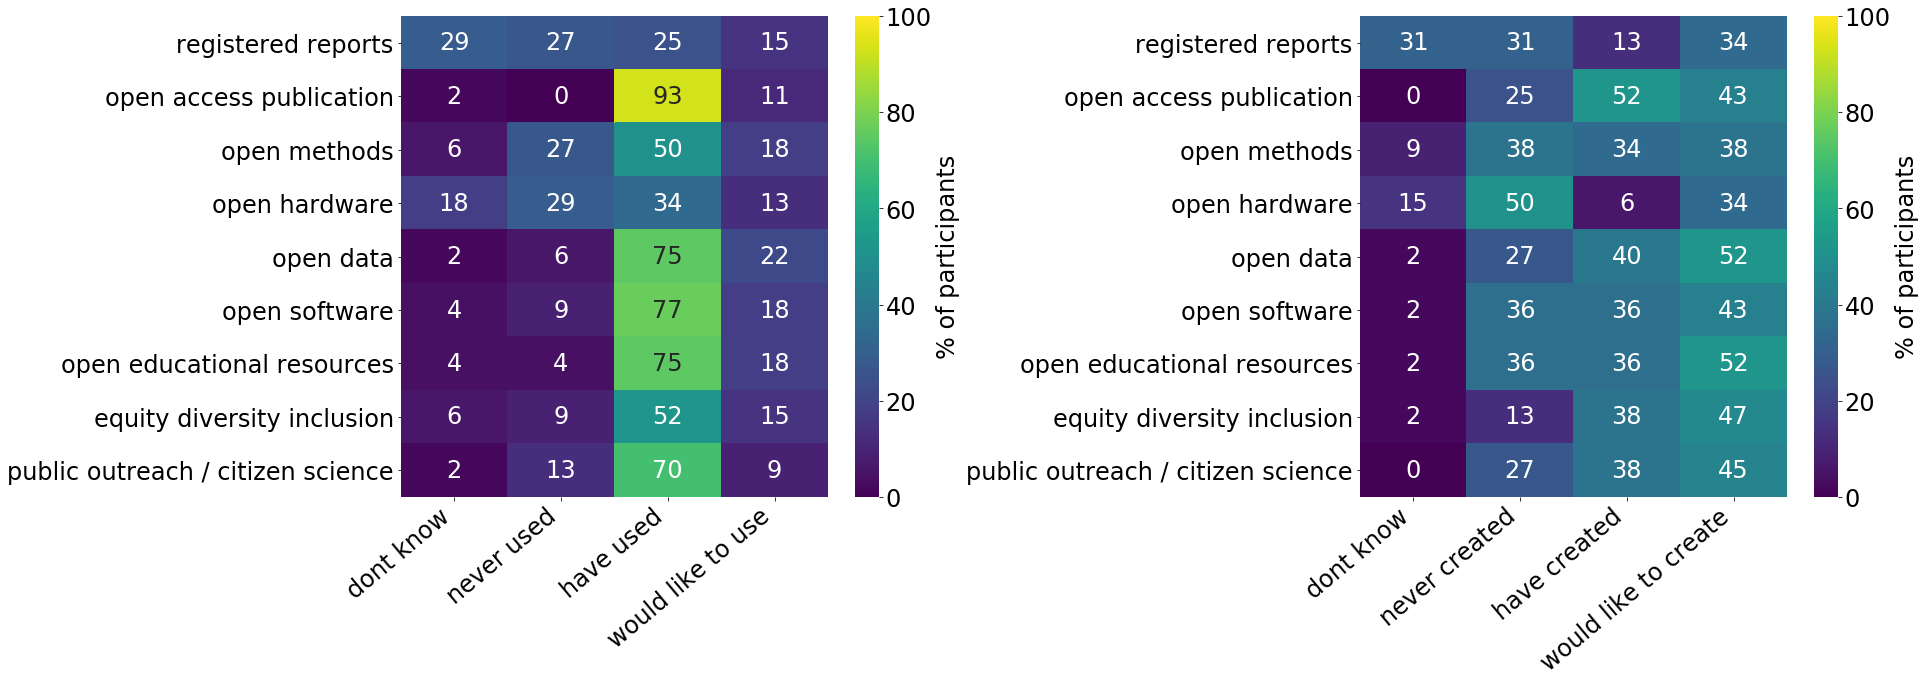

In [11]:
def ticklabels(var_list):
    return [
        s.replace("use_", "")
        .replace("create_", "")
        .replace("_", " ")
        .replace("each cit", "each / cit")
        for s in var_list
    ]


matplotlib.rcParams.update({"font.size": 24})
fig, axs = plt.subplots(1, 2, figsize=(27, 10))
vmax = 100
cmap = "viridis"
cbar = True
annot = True

create_cols = [col for col in list(mat.columns) if "create_" in col]
create_keys = [
    "dont_know",
    "never_created",
    "have_created",
    "would_like_to_create",
]
sns.heatmap(
    mat.loc[create_keys, create_cols].T,
    annot=annot,
    vmax=vmax,
    ax=axs[1],
    cbar=cbar,
    cmap=cmap,
    cbar_kws={"label": "% of participants"},
)
#     cbar_kws={'label': 'Number of participants'})
# axs[0].set_title("Experience CREATING open-science objects\n", fontsize=20)
axs[1].set_yticklabels(ticklabels(create_cols))
axs[1].set_xticklabels(ticklabels(create_keys), rotation=40, ha="right")

use_cols = [col for col in list(mat.columns) if "use_" in col]
use_keys = ["dont_know", "never_used", "have_used", "would_like_to_use"]
sns.heatmap(
    mat.loc[use_keys, use_cols].T,
    annot=annot,
    vmax=vmax,
    ax=axs[0],
    cbar=cbar,
    cmap=cmap,
    cbar_kws={"label": "% of participants"},
)
#             cbar_kws={'label': 'Number of participants'})
# axs[1].set_title("Experience USING open-science objects\n", fontsize=20)
axs[0].set_yticklabels(ticklabels(use_cols))
axs[0].set_xticklabels(ticklabels(use_keys), rotation=40, ha="right")

plt.tight_layout()
extent = (
    axs[1]
    .get_tightbbox(fig.canvas.renderer)
    .transformed(fig.dpi_scale_trans.inverted())
)
fig.savefig("figures/experience_creating.png", bbox_inches=extent)

extent = (
    axs[0]
    .get_tightbbox(fig.canvas.renderer)
    .transformed(fig.dpi_scale_trans.inverted())
)
fig.savefig("figures/experience_using.png", bbox_inches=extent)

plt.savefig("figures/experience.png", bbox_inches="tight")

## Overlap of creaters and users

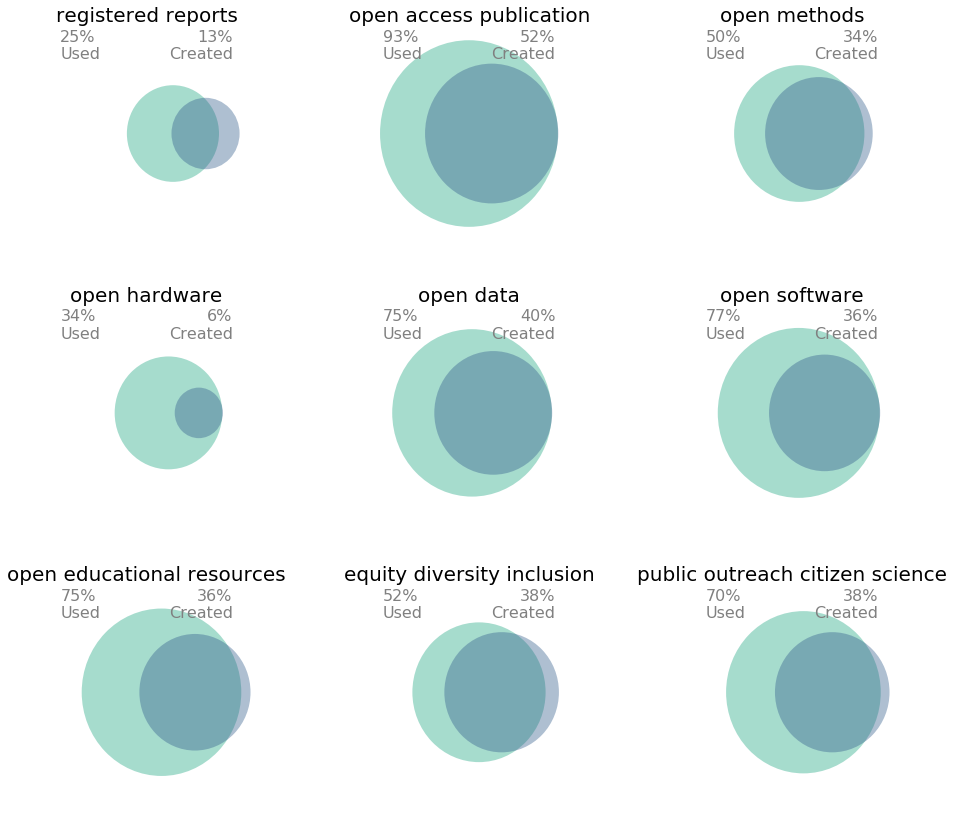

In [12]:


def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """

    if d <= abs(R - r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r) ** 2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r ** 2, R ** 2, d ** 2
    alpha = np.arccos((d2 + r2 - R2) / (2 * d * r))
    beta = np.arccos((d2 + R2 - r2) / (2 * d * R))
    return (
        r2 * alpha
        + R2 * beta
        - 0.5 * (r2 * np.sin(2 * alpha) + R2 * np.sin(2 * beta))
    )


def find_d(A, R, r):
    """
    Find the distance between the centres of two circles giving overlap area A.

    """
    R = R + 0.0001
    r = r + 0.0001

    # A cannot be larger than the area of the smallest circle!
    if A > np.pi * min(r, R) ** 2:
        raise ValueError(
            "Intersection area can't be larger than the area"
            " of the smallest circle"
        )
    if A == 0:
        # If the circles don't overlap, place them next to each other
        return R + r

    if A < 0:
        raise ValueError("Negative intersection area")

    def f(d, A, R, r):
        return intersection_area(d, R, r) - A

    a, b = abs(R - r), R + r
    d = brentq(f, a, b, args=(A, R, r))
    return d


fig, axs = plt.subplots(3, 3, figsize=(14, 12))

axs_nos = [
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2],
]

i_col = 0
for use_col, create_col, [fig_x, fig_y] in zip(use_cols, create_cols, axs_nos):
    i_used = df_cleaned[use_col].str.contains("have_used")
    i_used = i_used.fillna(False)
    n_used = i_used.sum()

    i_created = df_cleaned[create_col].str.contains("have_created")
    i_created = i_created.fillna(False)
    n_created = i_created.sum() + 0.01

    i_both = (i_used * 1) + (i_created * 1) > 1
    n_both = i_both.sum()

    # calculate distance between the two circles so that the
    # overlap area is proportional to the intersection
    overlap_area = n_both
    radius_used = np.sqrt(n_used / np.pi)
    radius_created = np.sqrt(n_created / np.pi)
    dist_between_circles = find_d(overlap_area, radius_used, radius_created)

    # Calculate the x coords that give the desired distance between the circles
    y = -0.1
    x_used = dist_between_circles - n_used / len(df)
    x_created = dist_between_circles + x_used

    # create the circles
    circles = []
    for x, r, color in zip(
        [x_used, x_created], [radius_used, radius_created], ["green", "blue"]
    ):
        circles.append(Circle((x, y), r, linestyle="-"))

    p = PatchCollection(circles, alpha=0.4, cmap=cmap)
    p.set_clim([0, 10])
    colors = np.array([6, 3])
    p.set_array(colors)
    axs[fig_x, fig_y].add_collection(p)
    lim = 5
    axs[fig_x, fig_y].set_ylim([-lim, lim - 1])
    axs[fig_x, fig_y].set_xlim([-lim, lim])
    axs[fig_x, fig_y].axis("off")

    percent_used = int(n_used / len(df) * 100)
    percent_created = int(n_created / len(df) * 100)
    axs[fig_x, fig_y].annotate(
        "%d%%\nUsed" % percent_used, xy=(-3.5, 2.8), fontsize=16, color="grey"
    )
    axs[fig_x, fig_y].annotate(
        "%d%%\nCreated" % percent_created,
        xy=(3.5, 2.8),
        ha="right",
        fontsize=16,
        color="grey",
    )

    axs[fig_x, fig_y].set_title(use_col[4:].replace("_", " "), fontsize=20)

plt.tight_layout()
plt.savefig("figures/intersections_use_create.png", bbox_inches="tight")

## Clustering types of participants

In [13]:
# getting the data in the right format
to_encode = df_cleaned[create_use_cols].dropna()

one_hot_df = pd.DataFrame()
for column in list(to_encode.columns):
    for option in create_use_keys:
        one_hot_column = column + "__" + option
        for i_row, row in to_encode.iterrows():
            if option in row[column]:
                one_hot_df.at[i_row, one_hot_column] = True

one_hot_df = one_hot_df.fillna(False)
X = one_hot_df.to_numpy()

Explained variance ratio:  [0.21356678 0.11754923]
Singular values:  [8.47016581 6.28398247]


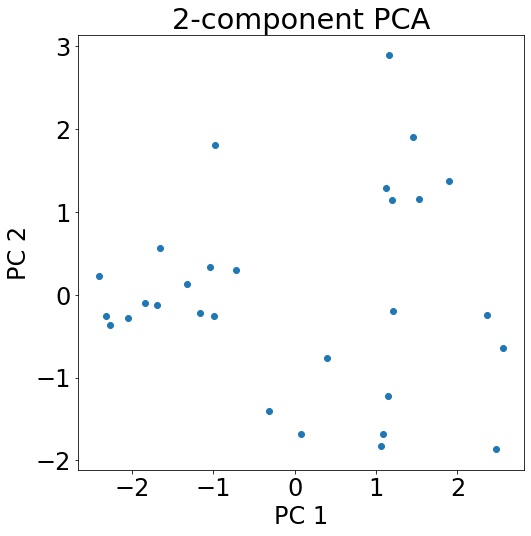

In [14]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X = one_hot_df.to_numpy()
principalComponents = pca.fit_transform(X)

print("Explained variance ratio: ", pca.explained_variance_ratio_)

print("Singular values: ", pca.singular_values_)

pca_df = pd.DataFrame(data=principalComponents, columns=["PC 1", "PC 2"])

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("%d-component PCA" % n_components)
ax.scatter(
    pca_df["PC 1"], pca_df["PC 2"],
)

## Barriers and desired resources

In [15]:
barriers_options = {
    "Limited knowledge": [
        "Limited knowledge - I don't know how to make my resarch more open",
        "Connaissances limitées - Je ne sais pas comment je peux rendre ma recherche plus ouverte",
    ],
    "Limited skills": [
        "Limited skills - I don't have the skills to make my research more open (e.g., technical skills in data management or programming)",
        "Compétences limitées - Je n'ai pas les compétences nécessaires pour rendre ma recherche plus ouverte (par exemple, compétences techniques en gestion de données ou en programmation)",
    ],
    "Limited time": [
        "Limited time - I don't have time to learn/do open science",
        "Contrainte de temps - Je n'ai pas le temps d'apprendre ce qui est requis pour faire de la science ouverte",
    ],
    "Limited support": [
        "Limited support - My colleagues and/or supervisors don't think that open science is a priority",
        "Soutien limité - Mes collègues et/ou superviseurs ne pensent pas que la science ouverte soit une priorité",
    ],
    "Limited incentives": [
        "Limited incentives - I don't see any personal incentives to do open science",
        "Motivation limitées - Je ne vois aucune incitation personnelle à faire de la science ouverte",
    ],
    "Not convinced": [
        "Not convinced - I don't think that open science is important",
        "Pas convaincu.e - Je ne pense pas que la science ouverte soit importante/ je n'en comprends pas la pertience",
    ],
}

resources_options = {
    "Resource list": [
        "Resource list - A list of open resources that I can go through on my own time",
        "Liste de ressources - Une liste de ressources ouvertes pouvant être consultées lors de mes temps libres",
    ],
    "Tutorials": [
        "Tutorials - Short tutorials/discussions that I can attend online",
        "Tutoriels - Petits tutoriels/discussions auxquels je peux assister en ligne",
    ],
    "Office hours": [
        "Office hours - Regular office hours where I can get 1-on-1 guidance for doing open science, considering my specific research, skills, and resources",
        "Heures d'ouverture du bureau - Heures de bureau destinées à des fins d'encadrement/consultation pendant lesquelles je peux obtenir des conseils personnalisés pour faire de la science ouverte, en tenant compte de mes recherches, compétences et ressources spécifiques",
    ],
}

In [16]:
matplotlib.rcParams.update({"font.size": 24})


def plot_categorical_column_with_comments(
    column,
    answer_options,
    ax,
    title=" ",
    plot_kind="barh",
    print_other_comments=True,
):

    # if a cell contains a string that matches a regex item,
    # replace the cell contents with the regex key
    column = column.dropna()
    keys = list(answer_options.keys())
    temp_df = pd.DataFrame(columns=keys)
    column = column.str.replace(
        "Heures de disponibilité / ", "Heures d'ouverture du bureau - "
    )
    temp_df["original_answer"] = column
    all_options = []
    for key, [en, fr] in answer_options.items():
        all_options.append(fr)
        all_options.append(en)

    for i, row in column.iteritems():
        for item in row.split(";"):
            for key, [en, fr] in answer_options.items():
                if item == en:
                    temp_df.at[i, key] = True
                if item == fr:
                    temp_df.at[i, key] = True
            if item not in all_options:
                temp_df.at[i, "Other"] = item
    temp_df[keys] = temp_df[keys].fillna(False)

    # plot
    to_plot = temp_df[keys].sum(axis=0) / len(temp_df) * 100
    to_plot.sort_values().plot(kind=plot_kind, ax=ax)
    #     ax.set_title(title + '\n')
    ax.set_xlim((0, 100))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("% of participants")

    # print other comments if desired
    if "Other" in list(temp_df.columns):
        if print_other_comments:
            other = []
            comments = list(temp_df["Other"].dropna())
            for s in comments:
                other = other + textwrap.wrap(s, width=70) + ["\n"]
            other = ["OTHER COMMENTS:\n\n"] + other
            other = "\n".join(other)
            other = other.replace("\n\n", "\n")
            props = dict(boxstyle="round", facecolor="whitesmoke", alpha=0.7)
            ax.text(
                1,
                0.85,
                other,
                fontsize=24,
                bbox=props,
                transform=plt.gcf().transFigure,
                verticalalignment="top",
            )

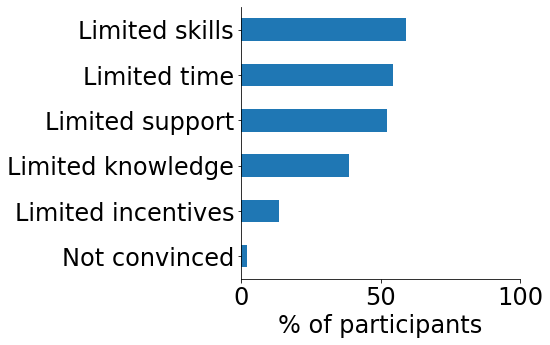

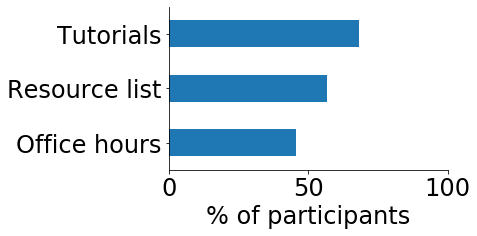

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_categorical_column_with_comments(
    column=df["barriers"],
    answer_options=barriers_options,
    ax=ax,
    title="What barriers do you face when trying to do open science?",
    plot_kind="barh",
    print_other_comments=False,
)
fig.savefig("figures/barriers.png", bbox_inches="tight")

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_categorical_column_with_comments(
    df["resources_youd_like"],
    resources_options,
    ax=ax,
    title="What would help you make your research more open?",
    plot_kind="barh",
    print_other_comments=False,
)
fig.savefig("figures/resources_youd_like.png", bbox_inches="tight")


## Would you be interested in applying to host Open Science Office Hours?

In [18]:
host_cols = ["host_paid", "host_volunteer"]
host_options = {"No": "No|Non", "Maybe": "Maybe|Peut", "Yes": "Yes|Qui"}
host_keys = list(host_options.keys())
host_mat = pd.DataFrame(columns=host_cols, index=host_keys)
for key, key_regex in host_options.items():
    for col in host_cols:
        host_mat.at[key, col] = (
            df[col].str.contains(key_regex, regex=True).sum()
            / n_participants
            * 100
        )
host_mat[host_cols] = host_mat[host_cols].astype(int)

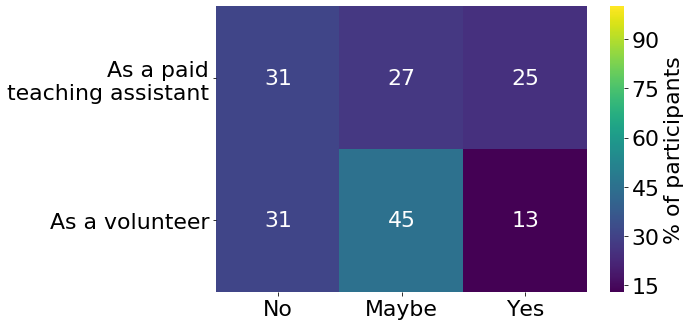

In [19]:
matplotlib.rcParams.update({"font.size": 22})
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    host_mat.T,
    annot=True,
    vmax=vmax,
    ax=ax,
    cbar=True,
    cmap=cmap,
    cbar_kws={"label": "% of participants"},
)
# ax.set_title(
#     "Would you be interested\nin applying to host\nOpen Science Office Hours?\n",
#     fontsize=20,
# )
ax.set_yticklabels(["As a paid\nteaching assistant", "As a volunteer"], rotation=0)
plt.tight_layout()
fig.savefig("figures/host.png", bbox_inches="tight")

## Open-ended questions

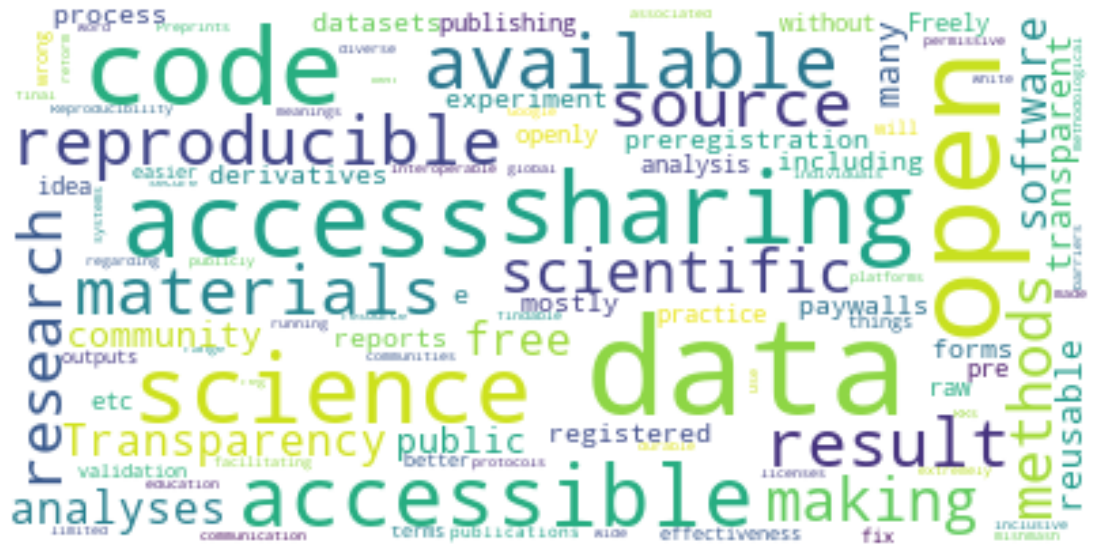

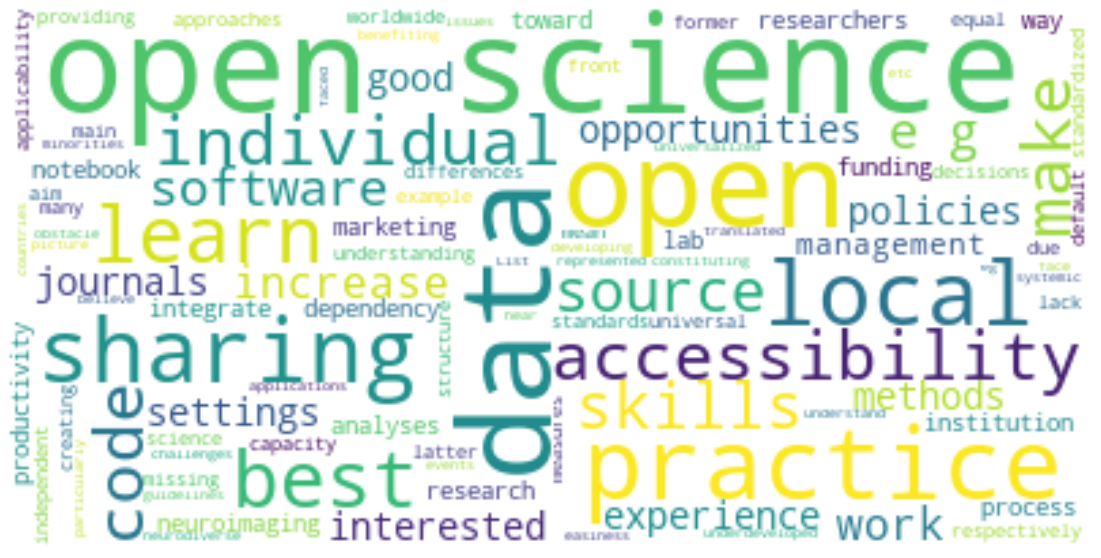

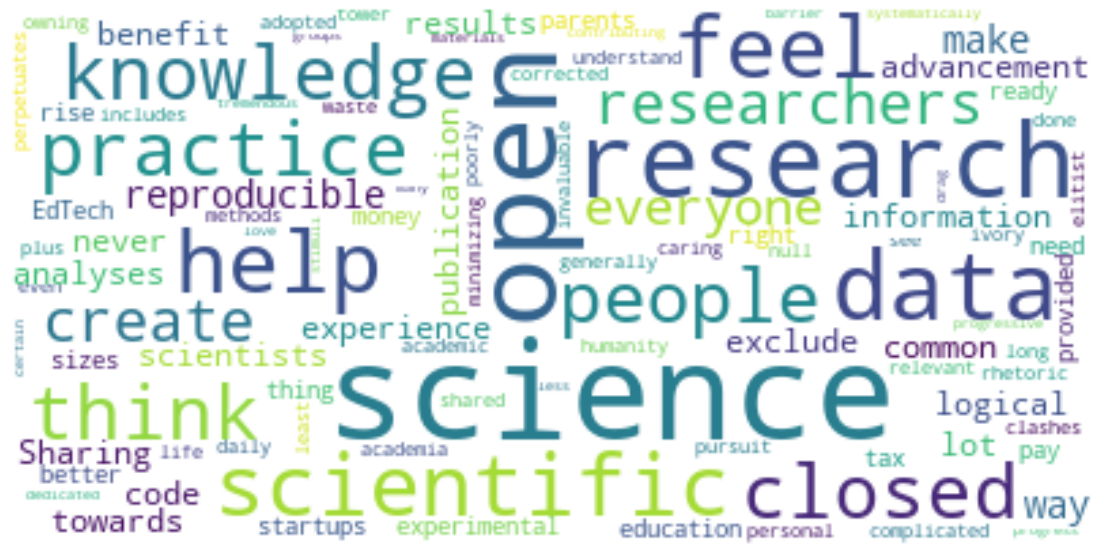

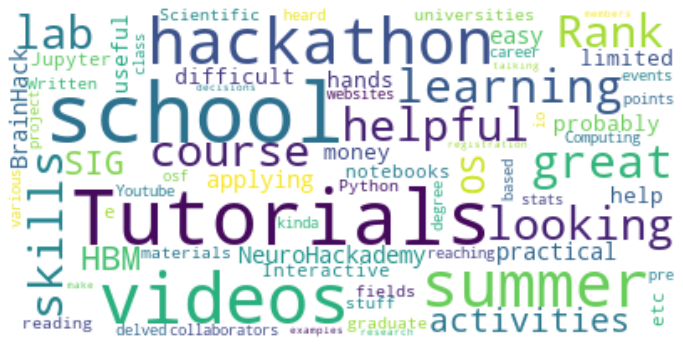

In [20]:
def all_answers_wordcloud(column, title="", language="all", figsize=(20, 10)):
    if language == "en":
        column = column[df["language"] == "English"]
    elif language == "fr":
        column = column[df["language"] == "Français"]

    column = column.dropna()

    # Concatenate the texts from all participants
    all_texts = ""
    for text in column:
        all_texts = all_texts + " " + str(text)

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(all_texts)

    # Display the generated image:
    wordcloud = WordCloud(
        max_font_size=50, max_words=100, background_color="white"
    ).generate(all_texts)

    fig, ax = plt.subplots(figsize=figsize)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(title + "\n", fontsize=40)
    plt.show()
    return fig, ax


# select language ('all', 'en', or 'fr')
language = "en"
fig, ax = all_answers_wordcloud(
    df["first_thoughts"],
    title='What do you think of when you hear the words "open science"?',
    language=language,
)
fig.savefig("figures/wc_first_thoughts.png", bbox_inches="tight")

fig, ax = all_answers_wordcloud(
    df["learn_next"],
    title="What would you like to learn about open science?",
    language=language,
)
fig.savefig("figures/wc_learn_next.png", bbox_inches="tight")


fig, ax = all_answers_wordcloud(
    df["motivation"],
    title="If you do open science,\nwhat motivates you to do so?",
    language=language,
)
fig.savefig("figures/wc_motivation.png", bbox_inches="tight")


fig, ax = all_answers_wordcloud(
    df["resources_that_helped"],
    title="If you do open science,\nwhat kinds of resources did you find most useful\nfor learning how to do open science?",
    language=language,
    figsize=(12, 8),
)
fig.savefig("figures/wc_resources_that_helped.png", bbox_inches="tight")

# Other analyses

### Visualizing the hourly wages of TAs in Canada
First let's get the data in a dataframe

In [21]:
ta_hourly_wages = {
    "U of Toronto": 46,
    "Ryerson U": 44,
    "U of Ottawa": 43,
    "U of Guelph": 42,
    "Queens U": 39,
    "York U": 37,
    "Brock U": 33,
    "U of Waterloo": 31,
    "McGill U": 29,
    "Concordia U": 28,
    "Wilfred Laurier U": 28,
    "McMaster U": 26,
    "Simon Fraser U": 26,
    "U of Victoria": 26,
    "Carleton U": 25,
    "U of Montreal": 23,
    "Dalhousie U": 23,
    "Polytechnique Montreal": 21,
    "U of British Columbia": 20,
    "U of Calgary": 19,
    "U of Alberta": 18,
}

data = np.array(
    [list(ta_hourly_wages.keys()), list(ta_hourly_wages.values())]
).T
ta_df = pd.DataFrame(data=data, columns=["University", "Hourly wage"])
ta_df["Hourly wage"] = ta_df["Hourly wage"].astype(int)
ta_df = ta_df.sort_values(by="Hourly wage")

Make the Montreal universities stand out in their color

In [22]:
us_in_montreal = [
    "McGill U",
    "Polytechnique Montreal",
    "Concordia U",
    "U of Montreal",
]
colors = []
for uni in list(ta_hourly_wages.keys()):
    if uni in us_in_montreal:
        color = "cornflowerblue"
    else:
        color = "lightgrey"
    colors.append(color)
colors = colors[::-1]

Aaaaand plot

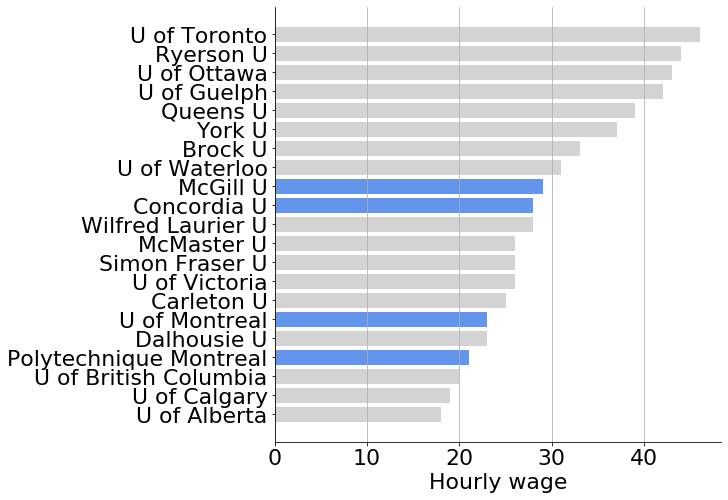

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.barh(ta_df["University"], ta_df["Hourly wage"], color=colors)
# ta_df.plot(kind='barh', ax=ax, legend=False, color=['r', 'g'])
x = ax.set_yticklabels(list(ta_df["University"]))
ax.grid(axis="x")
ax.set_xlabel("Hourly wage")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig("figures/ta_wages.png", bbox_inches="tight")

Mean and standard deviation of the TAs' hourly wages across Canada

In [24]:
print(np.mean(ta_df["Hourly wage"]), np.std(ta_df["Hourly wage"]))

29.857142857142858 8.53723337747637


## TA budget

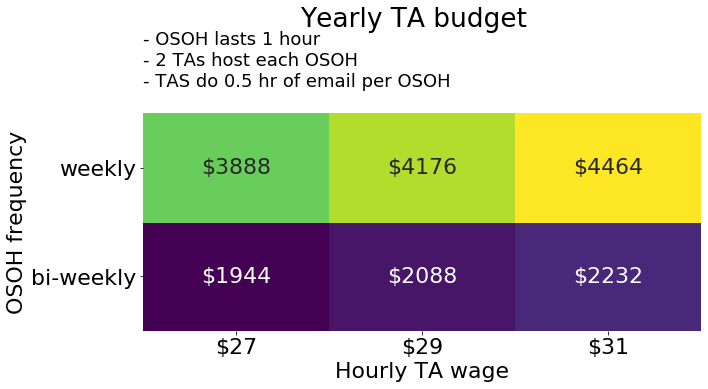

In [25]:
mean_ta_wage = 29.86
std_ta_wage = 8.54
possible_wages = np.arange(27, 32, 2)
possible_n_osohs = np.array([24, 48])

data = np.empty(shape=(len(possible_n_osohs), len(possible_wages)))
wage_df = pd.DataFrame(columns=possible_wages, index=possible_n_osohs)
n_tas = 2
n_hrs_for_email = .5

for n_osohs in possible_n_osohs:
    for wage in possible_wages:
        wage_df.at[n_osohs, wage] = np.round((n_tas * n_osohs * wage) + 
                                             (n_tas * n_hrs_for_email * n_osohs * wage))
        
    

fig, ax = plt.subplots(figsize=(10, 4))
wage_df = wage_df.astype(int)
sns.heatmap(
    wage_df,
    annot=True,
    fmt="d",
    ax=ax,
    cmap=cmap,
    cbar=False,
#     cbar_kws={"label": "Yearly TA budget"},
)

ax.invert_yaxis()
ylabels = [
    "bi-weekly",
    "weekly"
]
ax.set_yticklabels(ylabels, rotation=0)
ax.set_ylabel("OSOH frequency")

xlabels = ['$%d' %wage for wage in possible_wages]
ax.set_xticklabels(xlabels, rotation=0)
ax.set_xlabel("Hourly TA wage")

ax.set_title(("- OSOH lasts 1 hour\n" +\
              "- %d TAs host each OSOH\n" %n_tas +\
              "- TAS do %.1f hr of email per OSOH\n" %n_hrs_for_email),
            fontsize=18, loc='left')
for t in ax.texts:
    t.set_text("$" + t.get_text())
plt.suptitle("Yearly TA budget", y=1.25)
plt.savefig("figures/ta_budget.png", bbox_inches="tight")

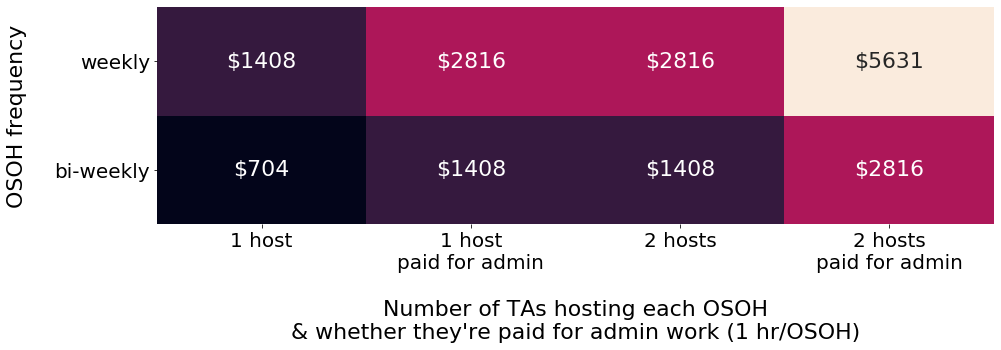

In [26]:
wage = 29.33

possible_n_osohs = [24, 48]
n_hrs_for_email = 1
possible_hrs_per_week = [1, 1 + 1*n_hrs_for_email, 2, 2 + 2*n_hrs_for_email]

data = np.empty(shape=(len(possible_hrs_per_week), len(possible_n_osohs)))
wage_df2 = pd.DataFrame(columns=possible_n_osohs)

for n_osohs in possible_n_osohs:
    for i_n_hrs, n_hrs in enumerate(possible_hrs_per_week):
        wage_df2.at[i_n_hrs, n_osohs] = np.round((n_osohs * n_hrs * wage))
wage_df2 = wage_df2.T
        
fig, ax = plt.subplots(figsize=(15, 4))
wage_df2 = wage_df2.astype(int)
sns.heatmap(
    wage_df2,
    annot=True,
    fmt="d",
    ax=ax,
#     cmap=cmap,
    cbar=False,
#     cbar_kws={"label": "Yearly TA budget"},
)

ax.invert_yaxis()
ylabels = [
    "bi-weekly",
    "weekly"
]
ax.set_yticklabels(ylabels, rotation=0, fontsize=20)
ax.set_ylabel("OSOH frequency\n")


xlabels = [
    "1 host",
    "1 host\npaid for admin",
    "2 hosts",
    "2 hosts\npaid for admin"
]
ax.set_xticklabels(xlabels, rotation=0, fontsize=20)
ax.set_xlabel("\nNumber of TAs hosting each OSOH\n& whether they're paid for admin work (%d hr/OSOH)" %n_hrs_for_email)

for t in ax.texts:
    t.set_text("$" + t.get_text())
# plt.suptitle("TA budget projections", y=1.1)
plt.savefig("figures/ta_budget.png", bbox_inches="tight")